# Training a ResNet-50 model to do land cover classification on EuroSAT


The [EuroSAT](https://github.com/phelber/EuroSAT) dataset is a dataset composed of 27,000 labelled images into 10 land cover categories. The dataset was manually splitted in two sets *test* and *train*, leaving 80% of the dataset for training and 20% for test. Each class has the same proportion of this split. Each image is a 64x64 pixel RGB image.

The images are transformed to be as consistent as possible with the recipe followed by He *et al* in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385): The images were converted to (C, H, W) tensors, then scaled so its values range from [0, 1] and then resized to have the shape (3, 224, 224).

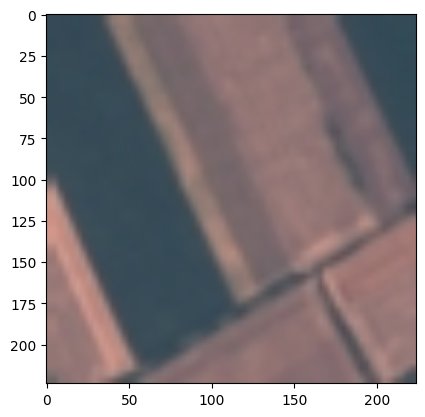

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils import data
from torchvision.datasets import ImageFolder
import torchvision.transforms.v2.functional as F

TRAIN_PERCENTAGE = 0.8
NUM_CLASSES = 11
CLASSES = [
    "Annual Crop",
    "Forest",
    "Herbaceous Vegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "Permanent Crop",
    "Residential",
    "River",
    "Sea-Lake",
    "background-class"]

def resnet_transforms(img):
    image = F.pil_to_tensor(img)
    image = image.float()
    image = image / 255
    image = F.resize(image, [224, 224])
    return image


def imshow(img):
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def print_loss_history(train_loss: list[float], val_loss: list[float]):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 8), )
    plt.plot(epochs, train_loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b--", label="Validation loss")
    plt.title("Training loss")
    plt.legend()
    plt.grid()
    plt.show()


dataset = ImageFolder("data/eurosat/train", transform=resnet_transforms)
testset = ImageFolder("data/eurosat/test", transform=resnet_transforms)
trainset, validationset = data.random_split(dataset, [TRAIN_PERCENTAGE, 1-TRAIN_PERCENTAGE])
imshow(dataset[1000][0])

The image above belongs to the class **Annual Crop**, it was transformed to a 224x224 RGB image. A batch size of 64 is used to load the images and do mini-batch training.

In [2]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

To speed up the training process, training and inference will be done in GPU.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


An instance of the **ResNet-50** architecture is created and loaded with ImageNet weights. By using a pretrained model which already knows how to recognise textures and shapes, we speed up the training process with a new dataset as it only needs to translate that knowledge to the new dataset.

Tha last layer of the original model will be modified so it outputs the probability of the input image to belong to a class. This is achieved by adding a *Softmax* function layer to the *fully connected* layer of the model.

In [4]:
from torch.nn import Linear, Sequential, Softmax
from torchvision.models import resnet
from torchvision.models.resnet import ResNet, ResNet50_Weights


def load_resnet_50() -> ResNet:
    model = resnet.resnet50(weights= ResNet50_Weights.IMAGENET1K_V2)
    model.fc = Sequential(
        Linear(model.fc.in_features, NUM_CLASSES),
        Softmax(1))
    return model


classifier = load_resnet_50()
classifier = classifier.to(device)

After several experiments with optimizers like `Adam` and `SGD`, learning rate schedulers and its hyperparameters, the following settings gave the best results as it can be seen in the loss plot:

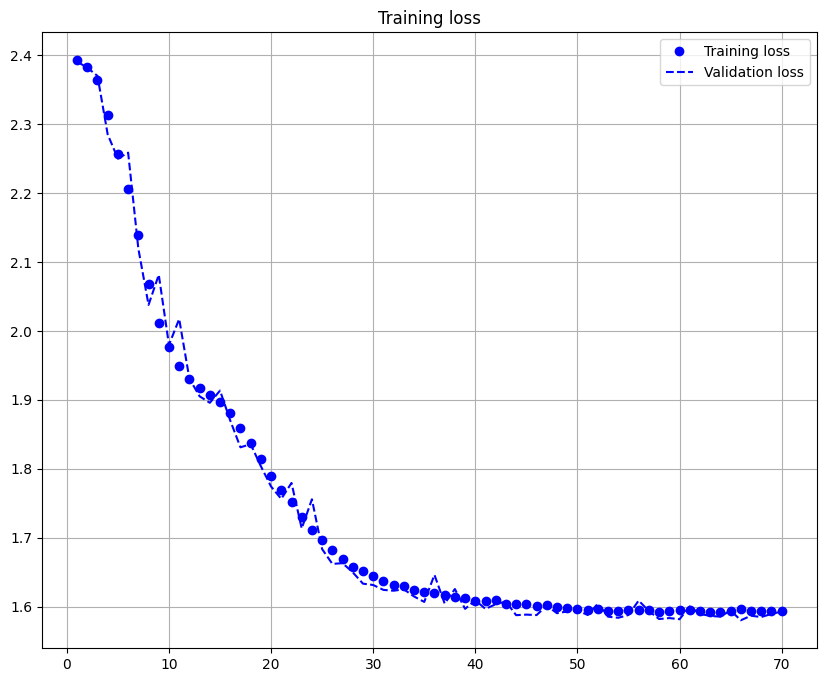

In [5]:
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau


LEARNING_RATE = 0.001
EPOCHS = 70
WEIGHT_DECAY = 0.001


criterion = CrossEntropyLoss()
optimizer = SGD(classifier.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, patience=5)
train_loss = []
validation_loss = []
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    classifier.train()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    val_loss = 0
    classifier.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(validation_loader)
    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    validation_loss.append(val_loss)
    scheduler.step(val_loss)
print_loss_history(train_loss, validation_loss)

To evaluate the performance of the current model we are going to use the validation set to measure the accuracy of the model.

In [6]:
from sklearn import metrics
from torch.utils.data import Dataset


def print_model_performance(model: ResNet, dataset: Dataset):
    predictions = []
    ground_truth = []
    classifier.eval()
    with torch.no_grad():
        for data in dataset:
            image, label = data[0].unsqueeze(0).to(device), data[1]
            prediction = model(image).cpu()
            predicted_class = torch.max(prediction, 1).indices.item()
            predictions.append(predicted_class)
            ground_truth.append(label)
    print(f"Accuracy: {metrics.accuracy_score(ground_truth, predictions):.5f}")


print_model_performance(classifier, validationset)

Accuracy: 0.95879


To train the final model, we will use the hyperparameters that gave the best results we found in the previous experiments with the train and validation set. By looking at the loss plot, the model got to its optimal state at epoch **60**, more training didn't improve the results significantly, hence this is the only hyperparameter that will be changed.

For the model to generalise better, we want to train it with as much data as possible. That is why for the final model, we will train it with the whole training dataset, that is without creating a validation dataset. The performance of the model will be evaluated with the test dataset, which contains data the model has never seen before.

In [7]:
EPOCHS = 60


classifier = load_resnet_50()
classifier = classifier.to(device)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
criterion = CrossEntropyLoss()
optimizer = SGD(classifier.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, patience=5)
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    classifier.train()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    classifier.eval()
    epoch_loss = running_loss / len(train_loader)
    scheduler.step(epoch_loss)

The performance of the final model is 0.9683: it generalises with great accuracy on new data.

In [8]:
print_model_performance(classifier, testset)

Accuracy: 0.96833


Finally, we are going to plot some of its predictions to show the results.

In [16]:
from torch import Tensor

def predict(model: ResNet, img: Tensor) -> str:
    model.eval()
    with torch.no_grad():
        image = img.unsqueeze(0).to(device)
        prediction = model(image).cpu()
        class_id = int(torch.max(prediction, 1).indices.item())
    class_name = CLASSES[class_id]
    return class_name

Residential


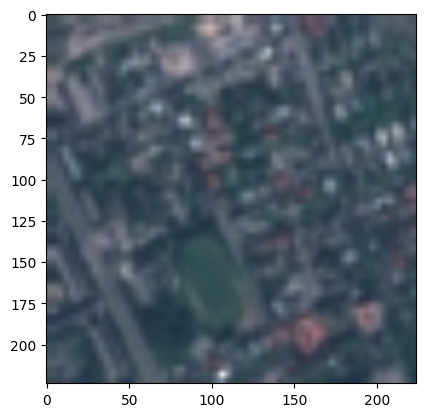

In [23]:
print(predict(classifier, testset[4000][0]))
imshow(testset[4000][0])

Forest


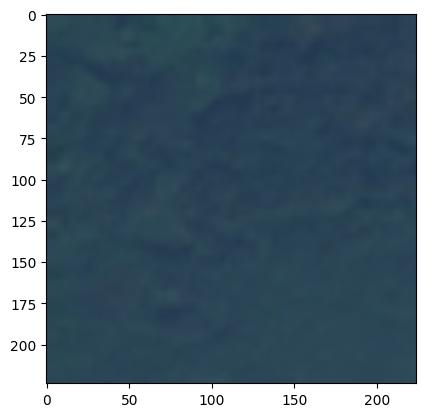

In [19]:
print(predict(classifier, testset[1000][0]))
imshow(testset[1000][0])

Highway


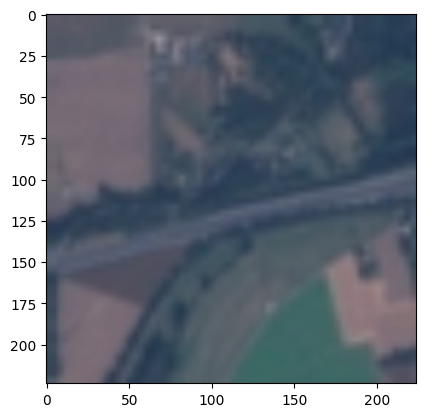

In [22]:
print(predict(classifier, testset[2000][0]))
imshow(testset[2000][0])